"Задание:

    1. Реализовать выбранный ранее алгоритм"

    2. Сранить результаты с алгоритмом из sklearn

    3. Выбить больший скор по сравнению со значением скора, которое было получено на прошлой лабораторной работе

    4. Выбрать "обратный" алгоритм (вместо классификации - регрессию и наоборот)

    5. Выбрать любой табличный набор данных для "обратного" алгоритма. Набор данных должен быть у каждого свой, то есть датасеты не должны пересекаться.
    
    6. Реализовать "обратный" алгоритм

# Лаборатораня работа #3

In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Реализация алгоритма случайный лес  

# Загрузка данных из первой ЛР

In [2]:
data = pd.read_csv('data/diabetes.csv')
data.head(10)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
5            5      116             74              0        0  25.6   
6            3       78             50             32       88  31.0   
7           10      115              0              0        0  35.3   
8            2      197             70             45      543  30.5   
9            8      125             96              0        0   0.0   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
5                     0.201   30        0  
6                     0.248   26        1  
7                     0.134   29        0  
8                     0.158   53        1  
9                     0.232   54        1

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
data.isnull().values.any()

False

В таблице нет пустых значений, все признаки являются численными.

Проанализирую распределение значений построив гистограммы признаков. 

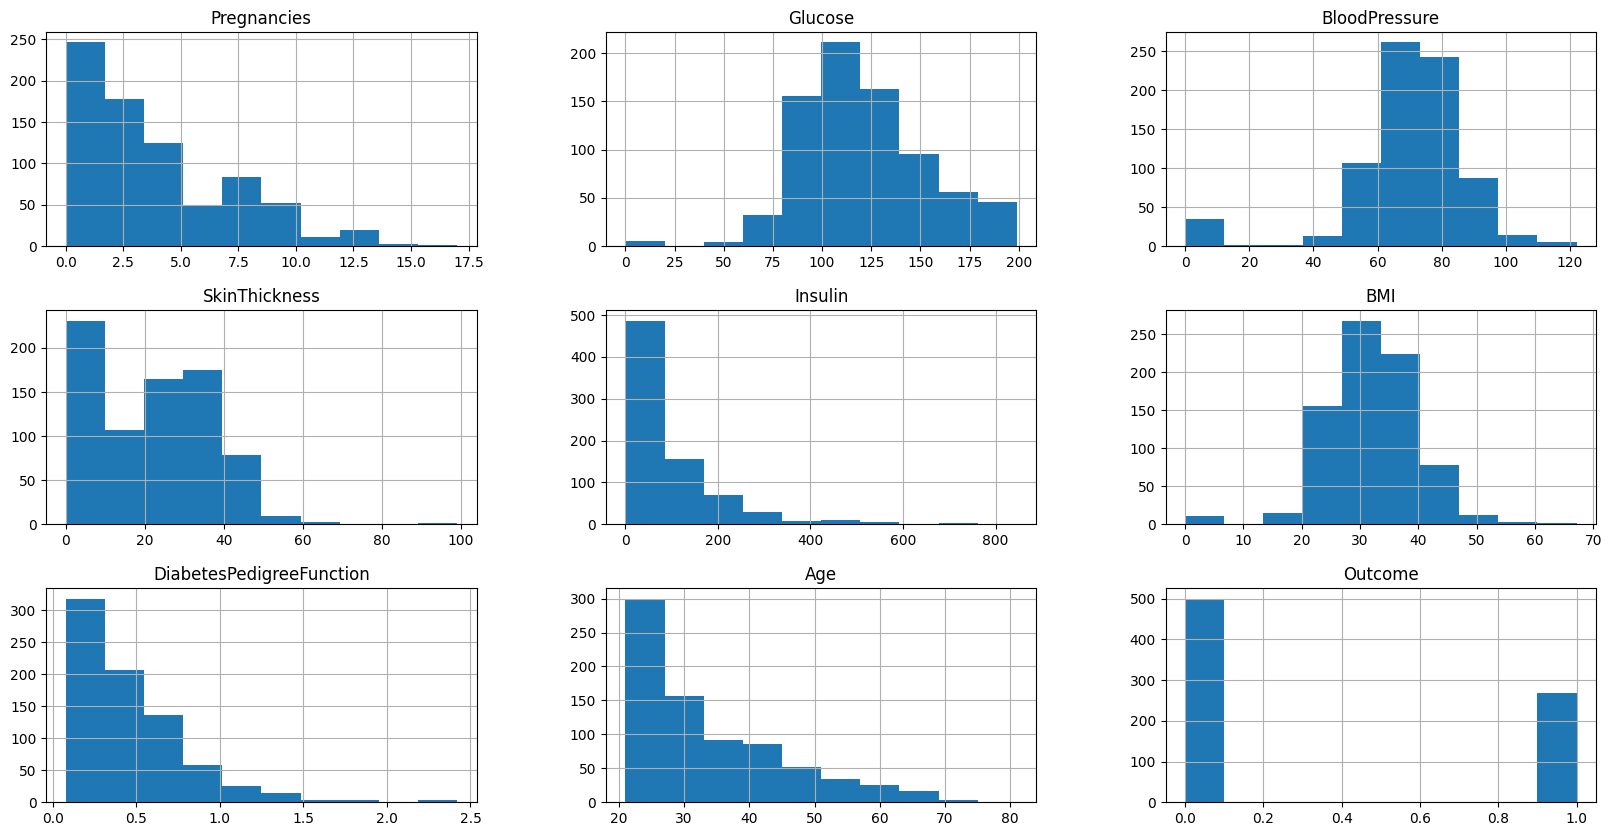

In [5]:
data.hist(column=data.columns, figsize=(20, 10))
None

<Figure size 1500x500 with 0 Axes>

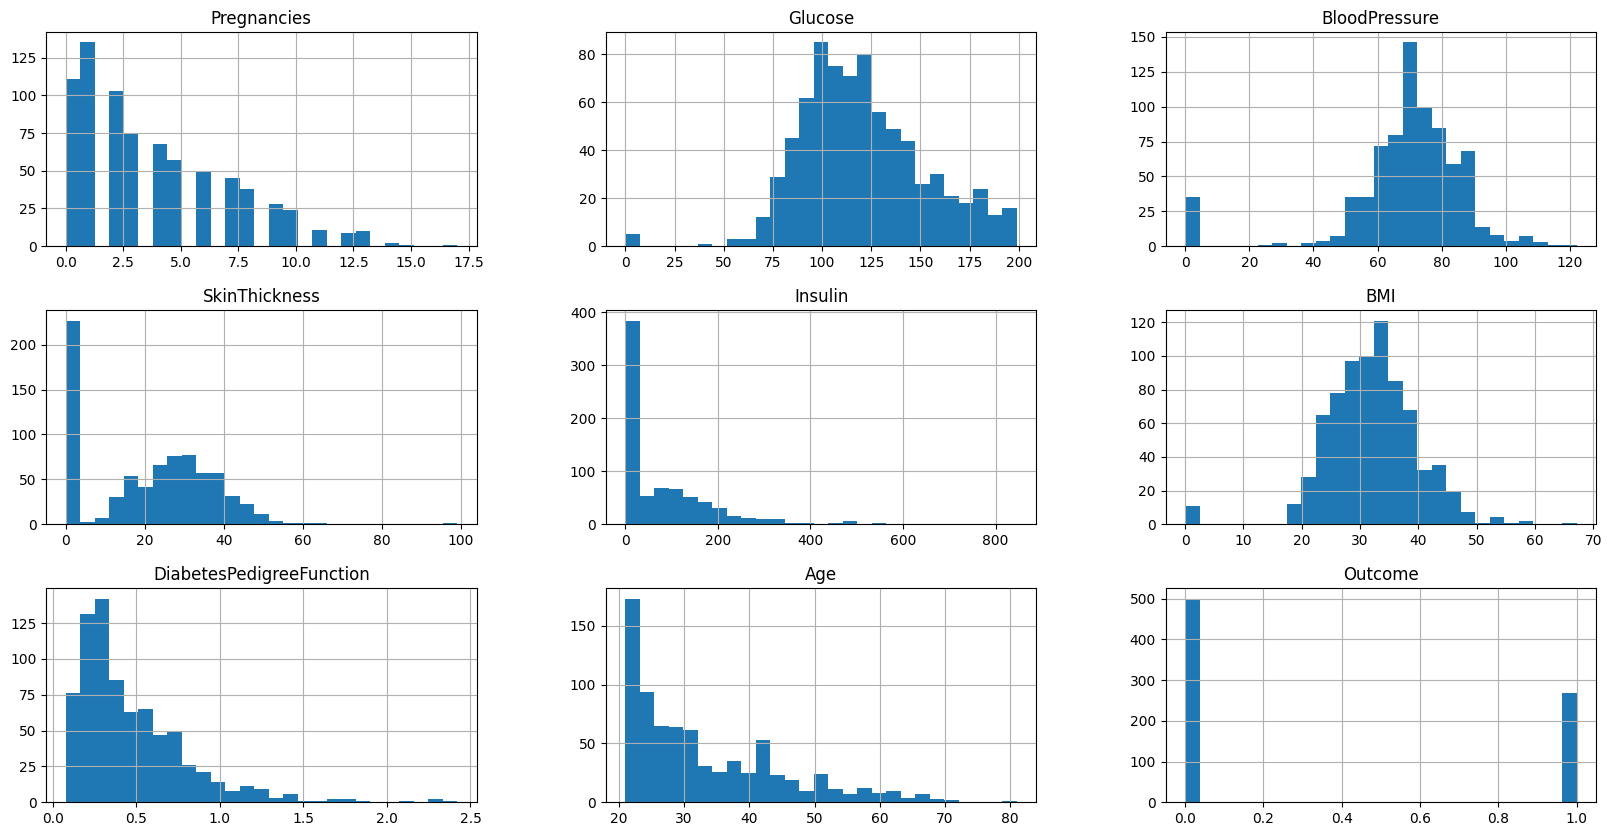

In [6]:
# Более мелкие слобцы
plt.figure(figsize=(15, 5))
binsNum = math.floor(math.sqrt(data.shape[0]))
data.hist(column=data.columns, bins=binsNum, figsize=(20, 10))
None

Похоже, что в признаках, отражающих количество инсулина, давления крови и толщины кожи ноль означает отсутствие информации. Удалять объекты с такими значениями не буду так как сам факт отсутствия анализа может быть полезен при выявлении закономерности. Соотношение значений целевого признака считаю приемлемым.

Визуализирую распределение признаков попарно

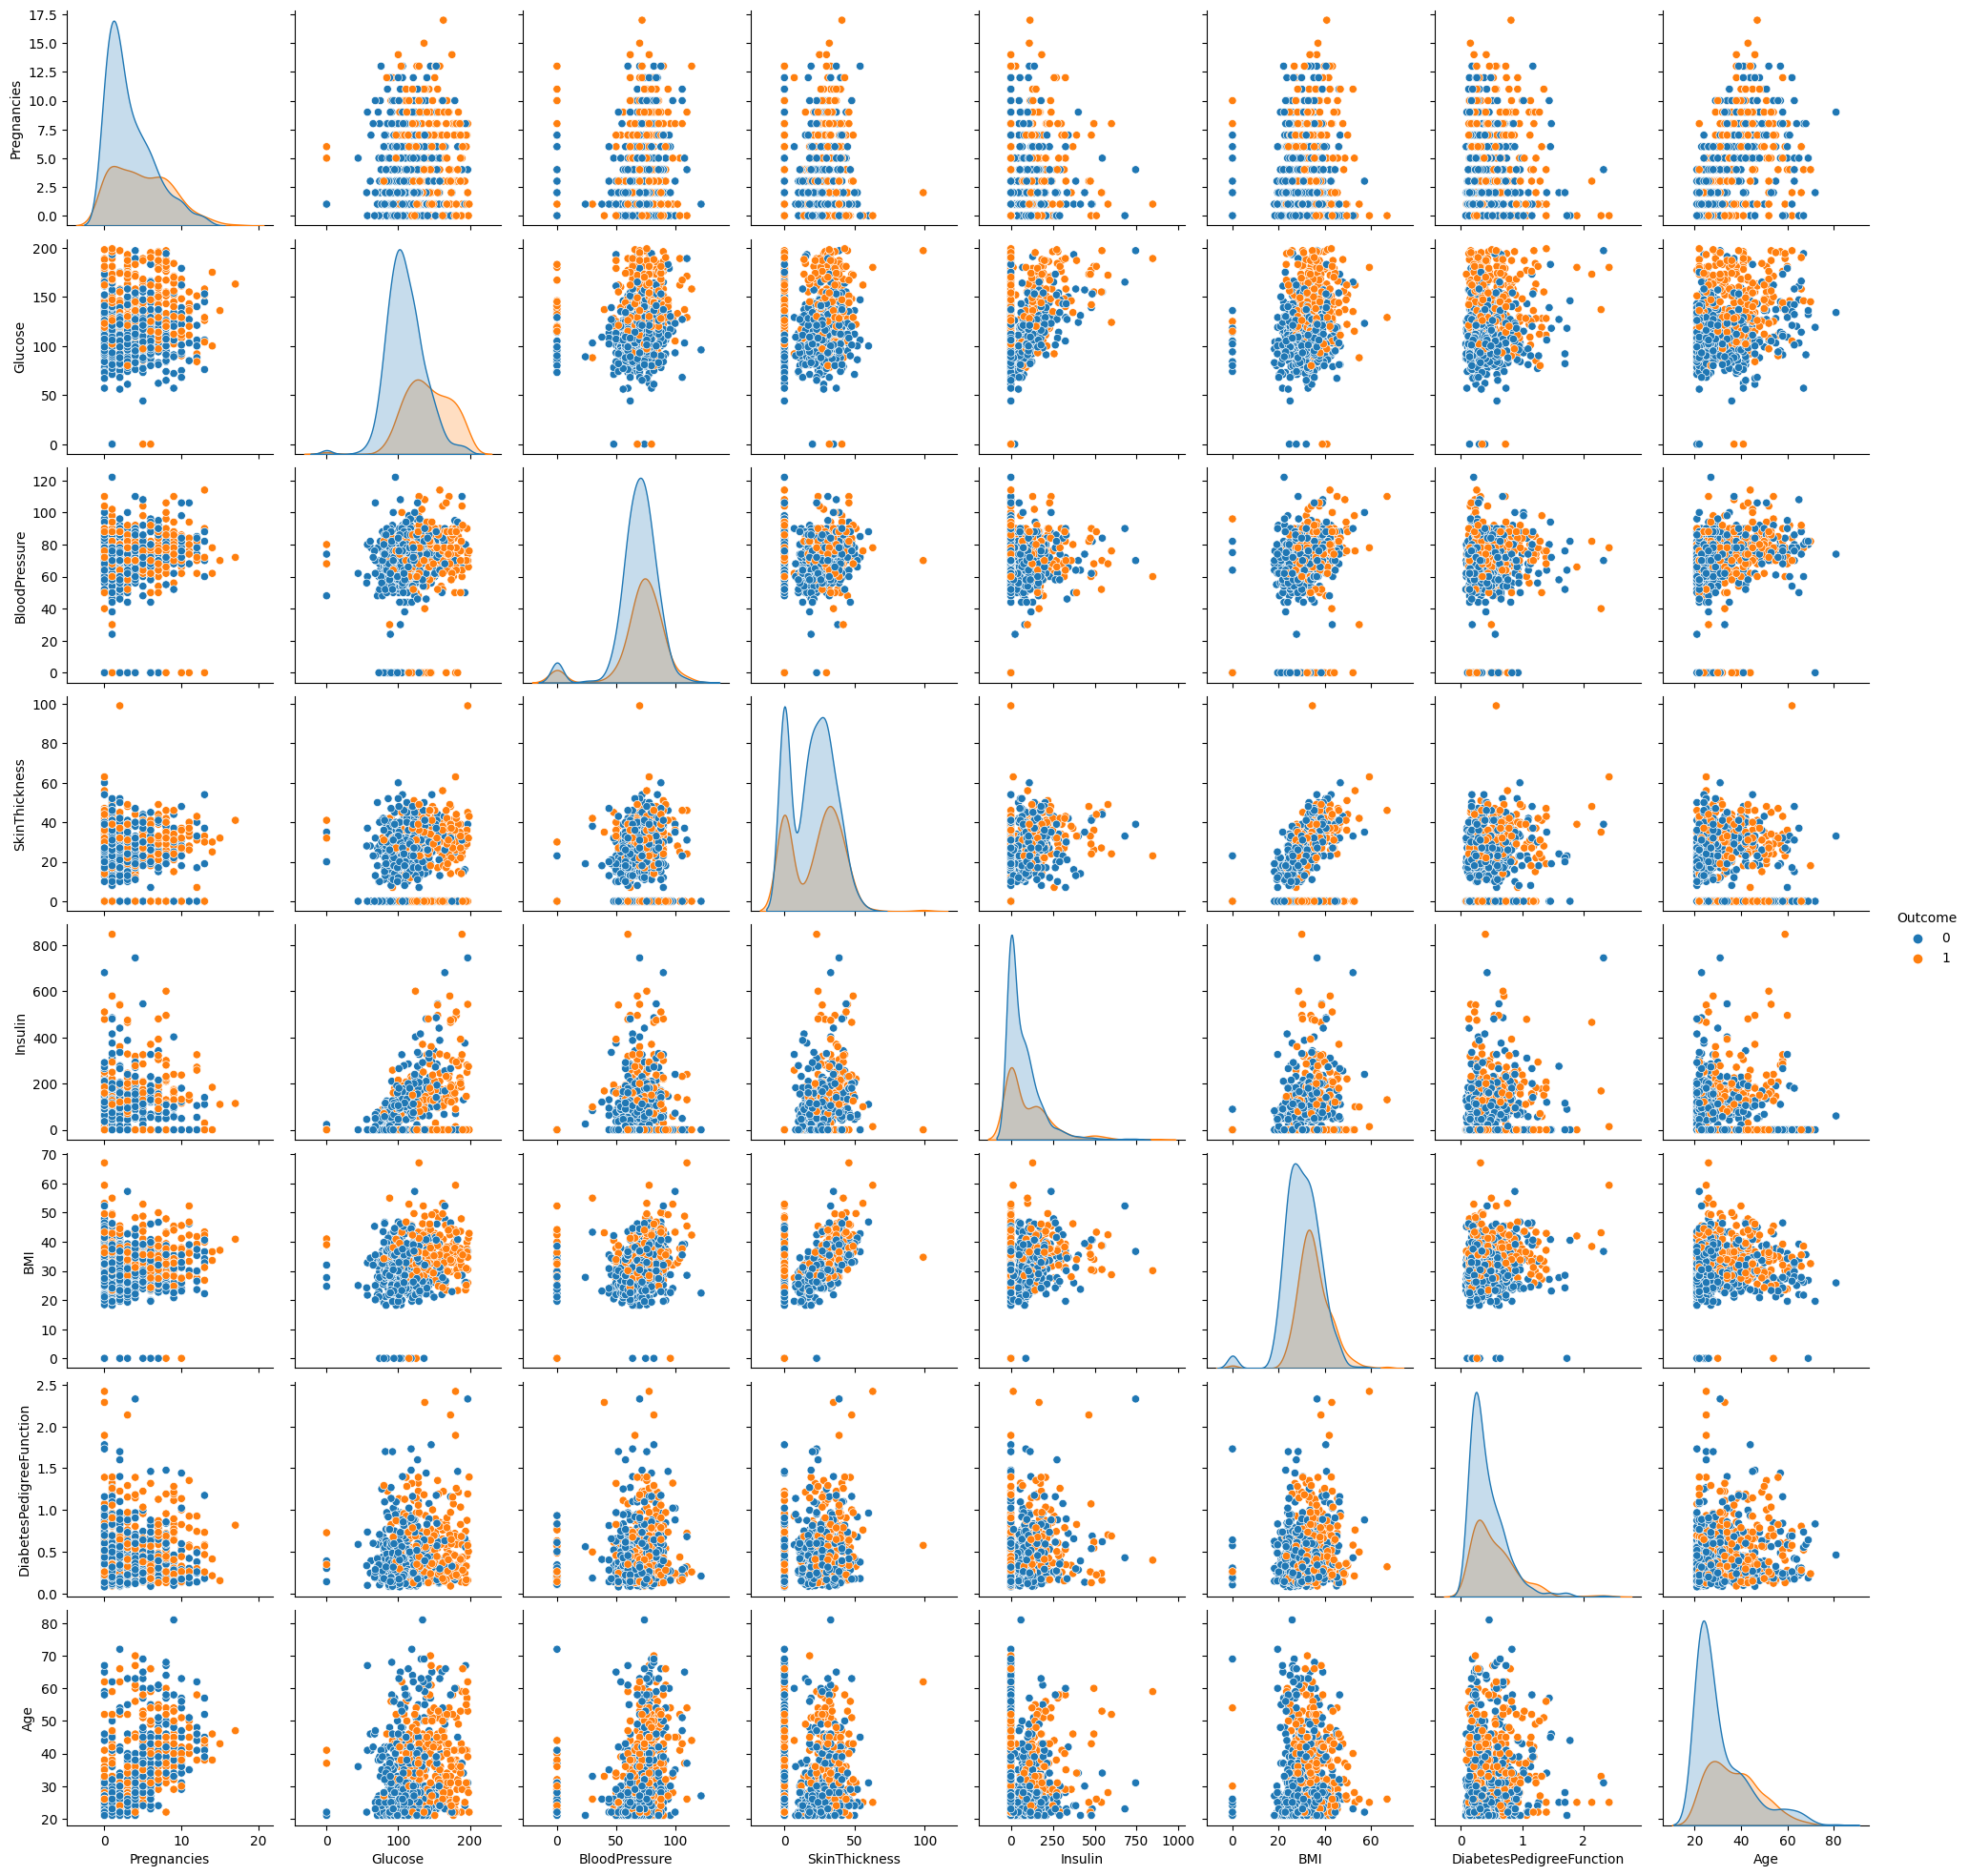

In [7]:
sns.pairplot(data=data, hue='Outcome')

Разделимость слабовыражена для некоторых пар. В основном, разделимость нетривиальна.

Взгляну на матрицу корреляций.

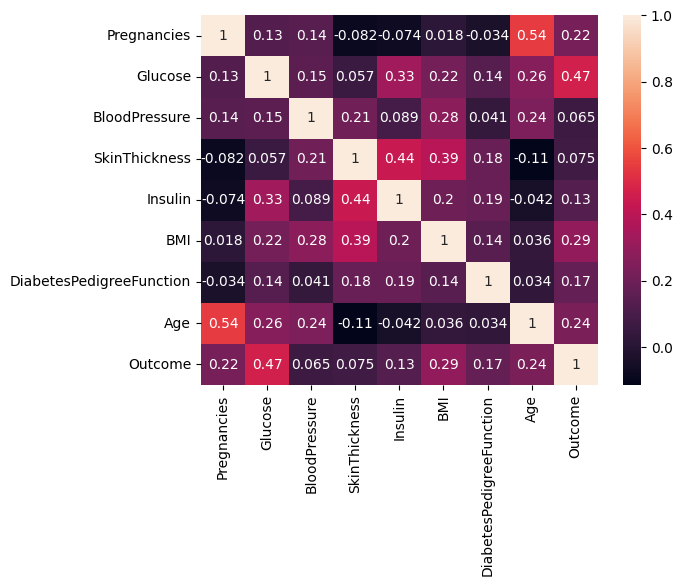

In [8]:
sns.heatmap(data.corr(), annot=True)
None

Явной мультиколлинеарности нет. Наибольшие значения имеют пары возраст/число беременностей и толщина кожи/инсулин.

Исходя из проведенного анализа, считаю данными пригодными для обучения модели. 

# Реализация модели: случайный лес

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin

def criterion(name, class_nums, n):
            if name == 'entropy':
                a = np.empty(len(class_nums))
                for i in range(len(class_nums)):
                    if class_nums[i] == 0:
                        a[i] = 0
                    else:
                        a[i] = (class_nums[i]/n)*np.log(class_nums[i]/n)
                return -sum(a)
            # if name == 'gini':
            #     p = class_nums/n
            #     return 1-np.sum(p**2)

class Decision_node:
        def __init__(self):
            self.prediction = None

class Decision_tree(BaseEstimator, ClassifierMixin):

    def fit_node(self, node, X, Y, features, ids, depth, min_leaf_size, classes, criterion_name):
        x = X[ids]
        y = Y[ids]
        n = len(x)

        if depth == 1 or len(ids) == 1 or len(ids) == 0:
            node.prediction = np.argmax(np.bincount(y))
            return

        class_nums = np.array([len(y[y == i]) for i in range(classes)])

        h = criterion(criterion_name, class_nums, n)

        max_gain = -1
        left_ids = None
        right_ids = None
        for feature in features:
            sorted_Ids = x[:, feature].argsort()
            
            left_n = 0
            left_classes_nums = np.zeros(classes)

            for i in range(n-1):
                left_n += 1
                left_classes_nums[y[sorted_Ids[i]]] += 1

                left_h = criterion(criterion_name, left_classes_nums, left_n)
                right_h = criterion(criterion_name, class_nums-left_classes_nums, n-left_n)

                gain = h - (left_n*left_h+(n-left_n)*right_h)/n

                if gain > max_gain:
                    max_gain = gain
                    node.feature = feature
                    node.value = x[sorted_Ids[i]][feature]
                    left_ids = sorted_Ids[:i+1]
                    right_ids = sorted_Ids[i+1:]

        if len(left_ids) < min_leaf_size or len(right_ids) < min_leaf_size:
            node.prediction = np.argmax(np.bincount(y))
            return

        node.left = Decision_node()
        node.right = Decision_node()

        self.fit_node(node.left, X, Y, features, left_ids, depth-1, min_leaf_size, classes, criterion_name)
        self.fit_node(node.right, X, Y, features, right_ids, depth-1, min_leaf_size, classes, criterion_name)

    def __init_(self):
        pass

    def fit(self, X, Y, features, depth, min_leaf_size, criterion_name):
        classes = len(np.unique(Y))
        self.root = Decision_node()
        self.fit_node(self.root, X, Y, features, np.arange(len(Y)), depth-1, min_leaf_size, classes, criterion_name)

    def predict(self, X):
        prediction = np.empty(X.shape[0])
        for i, object in enumerate(X):
            current_node = self.root
            while current_node.prediction == None:
                if object[current_node.feature] <= current_node.value:
                    current_node = current_node.left
                else:
                    current_node = current_node.right
            prediction[i] = current_node.prediction
        return prediction

In [10]:
class Random_forest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators = 10, criterion = 'entropy', max_depth = '5', min_samples_leaf = 2, max_features = None):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
    
    def fit(self, X, Y):
        features = np.arange(X.shape[1])
        

        self.forest = []
        for _ in range(self.n_estimators):
            np.random.shuffle(features)
            tree = Decision_tree()
            if self.max_features == 'sqrt':
                tree.fit(X, Y, features[:int(np.floor(np.sqrt(len(features))))], self.max_depth, self.min_samples_leaf, self.criterion)
            else:
                tree.fit(X, Y, features, self.max_depth, self.min_samples_leaf, self.criterion)

            self.forest.append(tree)
            if self.max_features == None:
                break

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.forest])
        forest_predictions = np.max(predictions, axis=0)
        return forest_predictions

# Обучение модели

In [11]:
import sklearn
import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data.drop('Outcome', axis=1).to_numpy(), 
                                                    data['Outcome'].to_numpy(), 
                                                    train_size=0.8)

Сразу использую кросс-валидацию, для поиска лучшего сочетания гепрепараметоров. Целевая метрика - точность.

In [22]:
random_forest_classifier_cv = sklearn.model_selection.GridSearchCV(Random_forest(),
                                                                  {'n_estimators': [10, 25, 50],
                                                                   'criterion': ['entropy'],
                                                                   'max_depth': [5, 6, 7, 8, 9],
                                                                   'min_samples_leaf': [1, 2, 3, 4],
                                                                   'max_features': ['sqrt', None]},
                                                                   scoring = 'accuracy')

random_forest_classifier_cv.fit(X_train, y_train)
print(random_forest_classifier_cv.best_params_, random_forest_classifier_cv.best_score_, sep='\n')

{'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 10}
0.7018792483006797


accuracy_score:  0.6363636363636364
recall_score:  0.2692307692307692


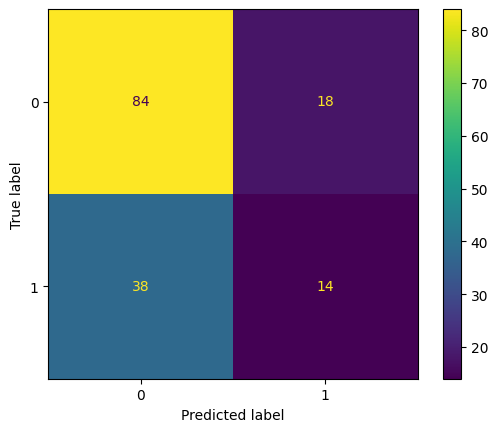

In [23]:
predictions =  random_forest_classifier_cv.best_estimator_.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)

print('accuracy_score: ', sklearn.metrics.accuracy_score(y_test, predictions))
print('recall_score: ', sklearn.metrics.recall_score(y_test, predictions))
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot()
None

Похоже, что лес переобучается. Изменю варианты подбираемых гиперпараметров. Не буду сделать слишком глубокие деревья.

In [19]:
random_forest_classifier_cv = sklearn.model_selection.GridSearchCV(Random_forest(),
                                                                  {'n_estimators': [10, 25, 50],
                                                                   'criterion': ['entropy'],
                                                                   'max_depth': [5, 6],
                                                                   'min_samples_leaf': [1, 2, 3],
                                                                   'max_features': ['sqrt', None]},
                                                                   scoring = 'accuracy')

random_forest_classifier_cv.fit(X_train, y_train)
print(random_forest_classifier_cv.best_params_, random_forest_classifier_cv.best_score_, sep='\n')

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 10}
0.6644275623084098


accuracy_score:  0.6883116883116883
recall_score:  0.38461538461538464


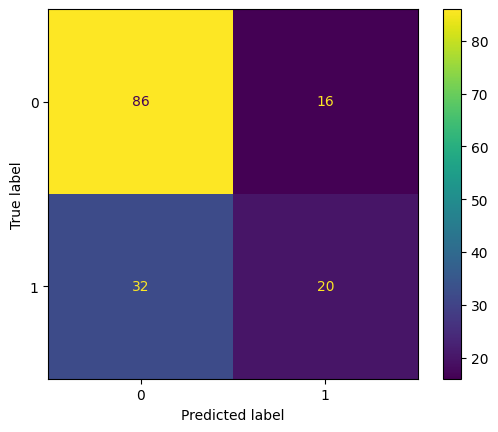

In [21]:
predictions =  random_forest_classifier_cv.best_estimator_.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)

print('accuracy_score: ', sklearn.metrics.accuracy_score(y_test, predictions))
print('recall_score: ', sklearn.metrics.recall_score(y_test, predictions))
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot()
None

В прошлой лабораторной работе точность случайного леса из sklearn на этих данных оказалась равна примерно 0.74. Добиться лучшего значения при самостоятельной реализации не удалось.

# Реализация алгоритма логистическая регрессия
# Загрузка и анализ данных

In [ ]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('data/water_potability.csv')
data.head(10)

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0        NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1   3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2   8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3   8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4   9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   
5   5.584087  188.313324  28748.687739     7.544869  326.678363    280.467916   
6  10.223862  248.071735  28749.716544     7.513408  393.663396    283.651634   
7   8.635849  203.361523  13672.091764     4.563009  303.309771    474.607645   
8        NaN  118.988579  14285.583854     7.804174  268.646941    389.375566   
9  11.180284  227.231469  25484.508491     9.077200  404.041635    563.885481   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
5        8.399735        54.917862   2.559708           0  
6       13.789695        84.603556   2.672989           0  
7       12.363817        62.798309   4.401425           0  
8       12.706049        53.928846   3.595017           0  
9       17.927806        71.976601   4.370562           0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Уберу все объекты с пустыми значениями в строке.

In [ ]:
data = data.dropna()

In [ ]:
data.isnull().values.any()

False

Проанализирую распределение значений построив гистограммы признаков. 

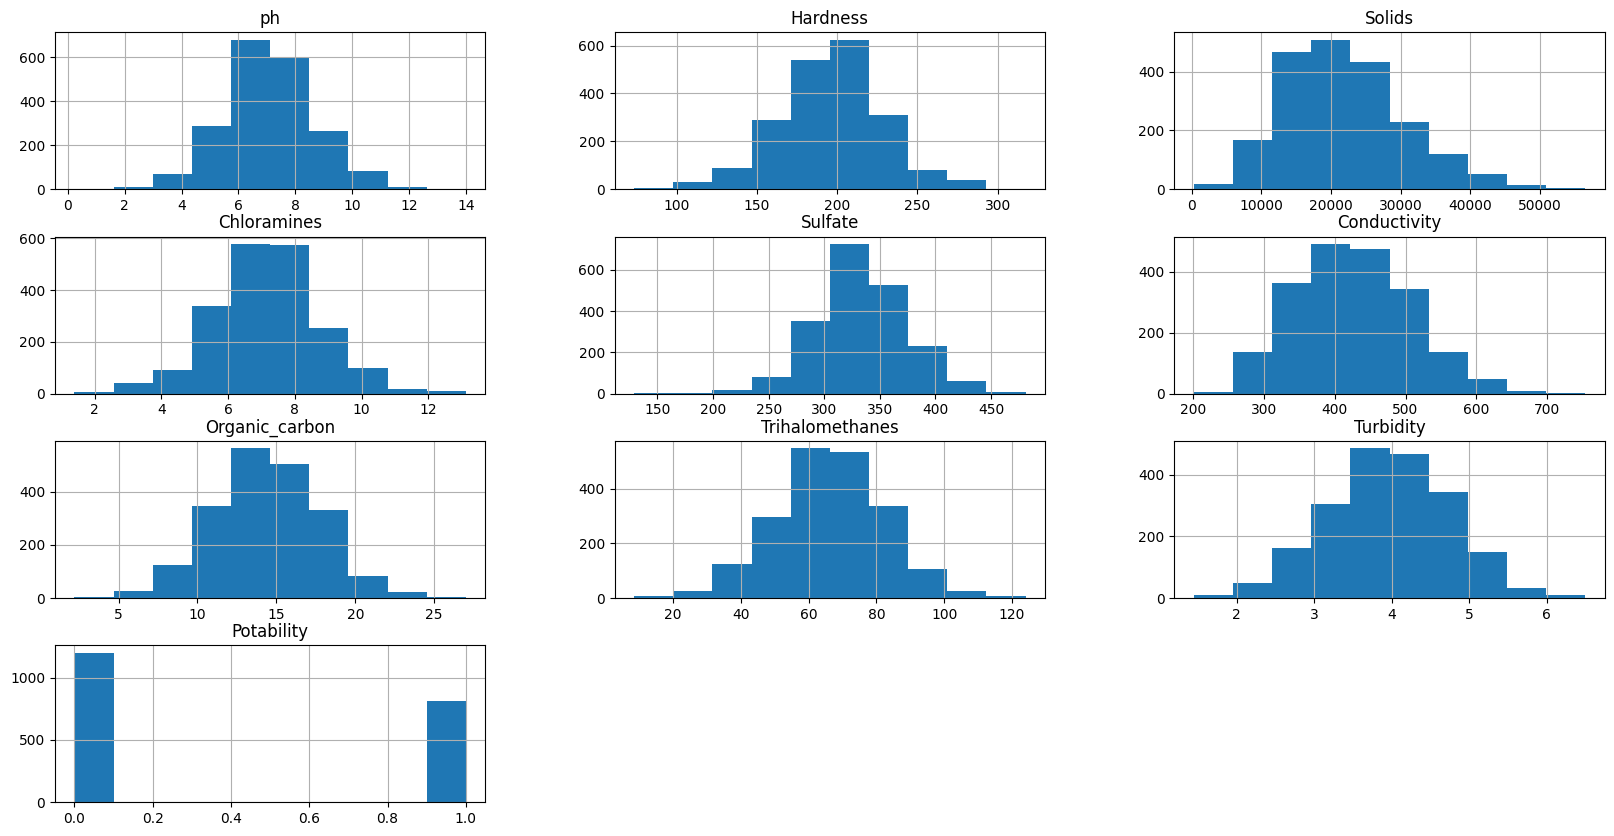

In [ ]:
data.hist(column=data.columns, figsize=(20, 10))
None

<Figure size 1500x500 with 0 Axes>

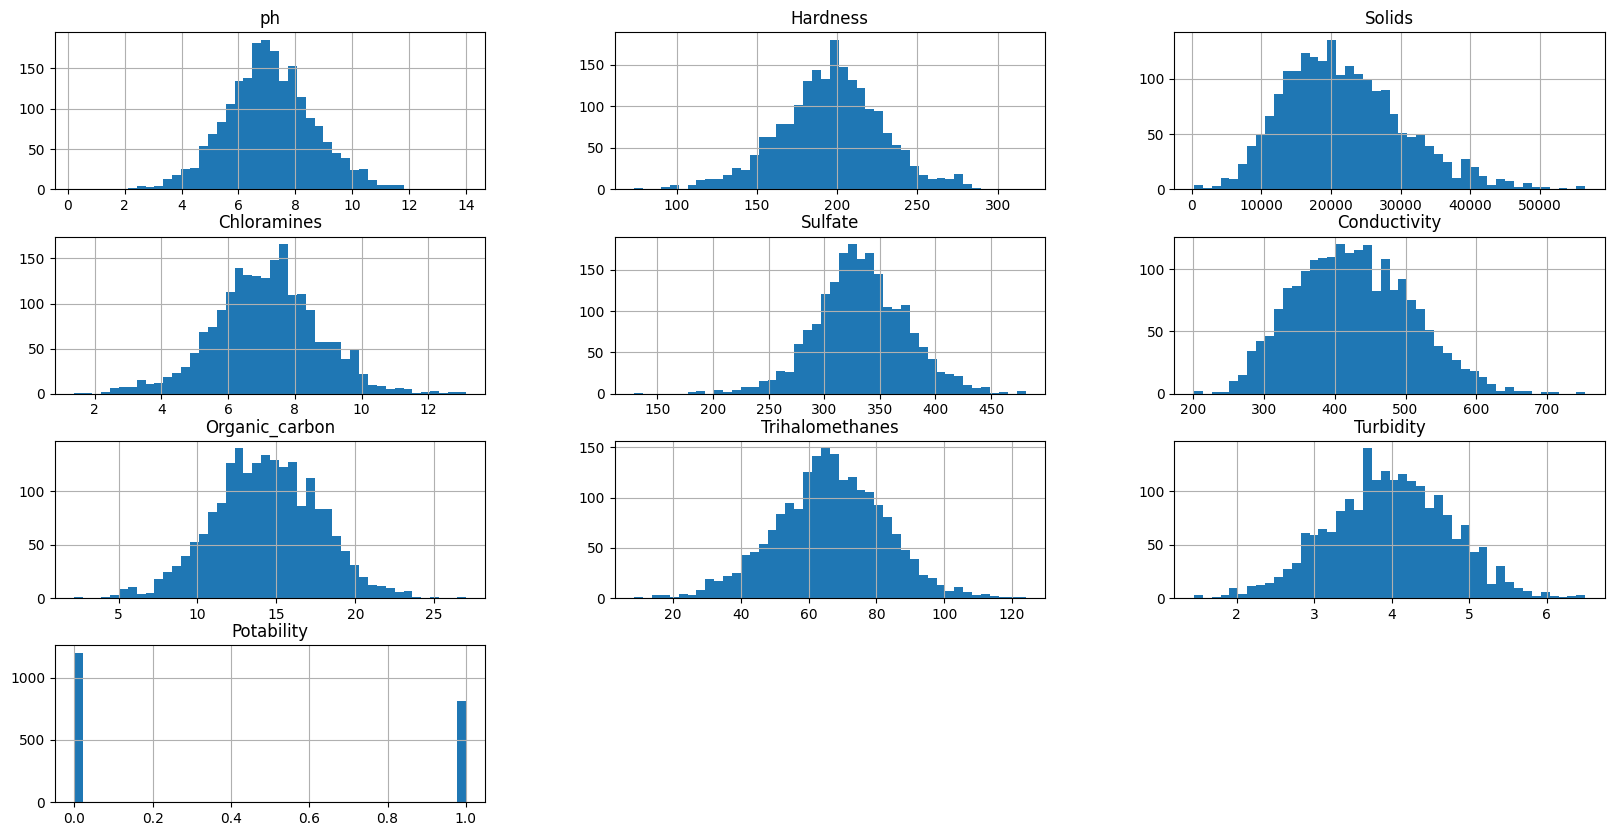

In [ ]:
# Более мелкие слобцы
plt.figure(figsize=(15, 5))
binsNum = math.floor(math.sqrt(data.shape[0]))
data.hist(column=data.columns, bins=binsNum, figsize=(20, 10))
None

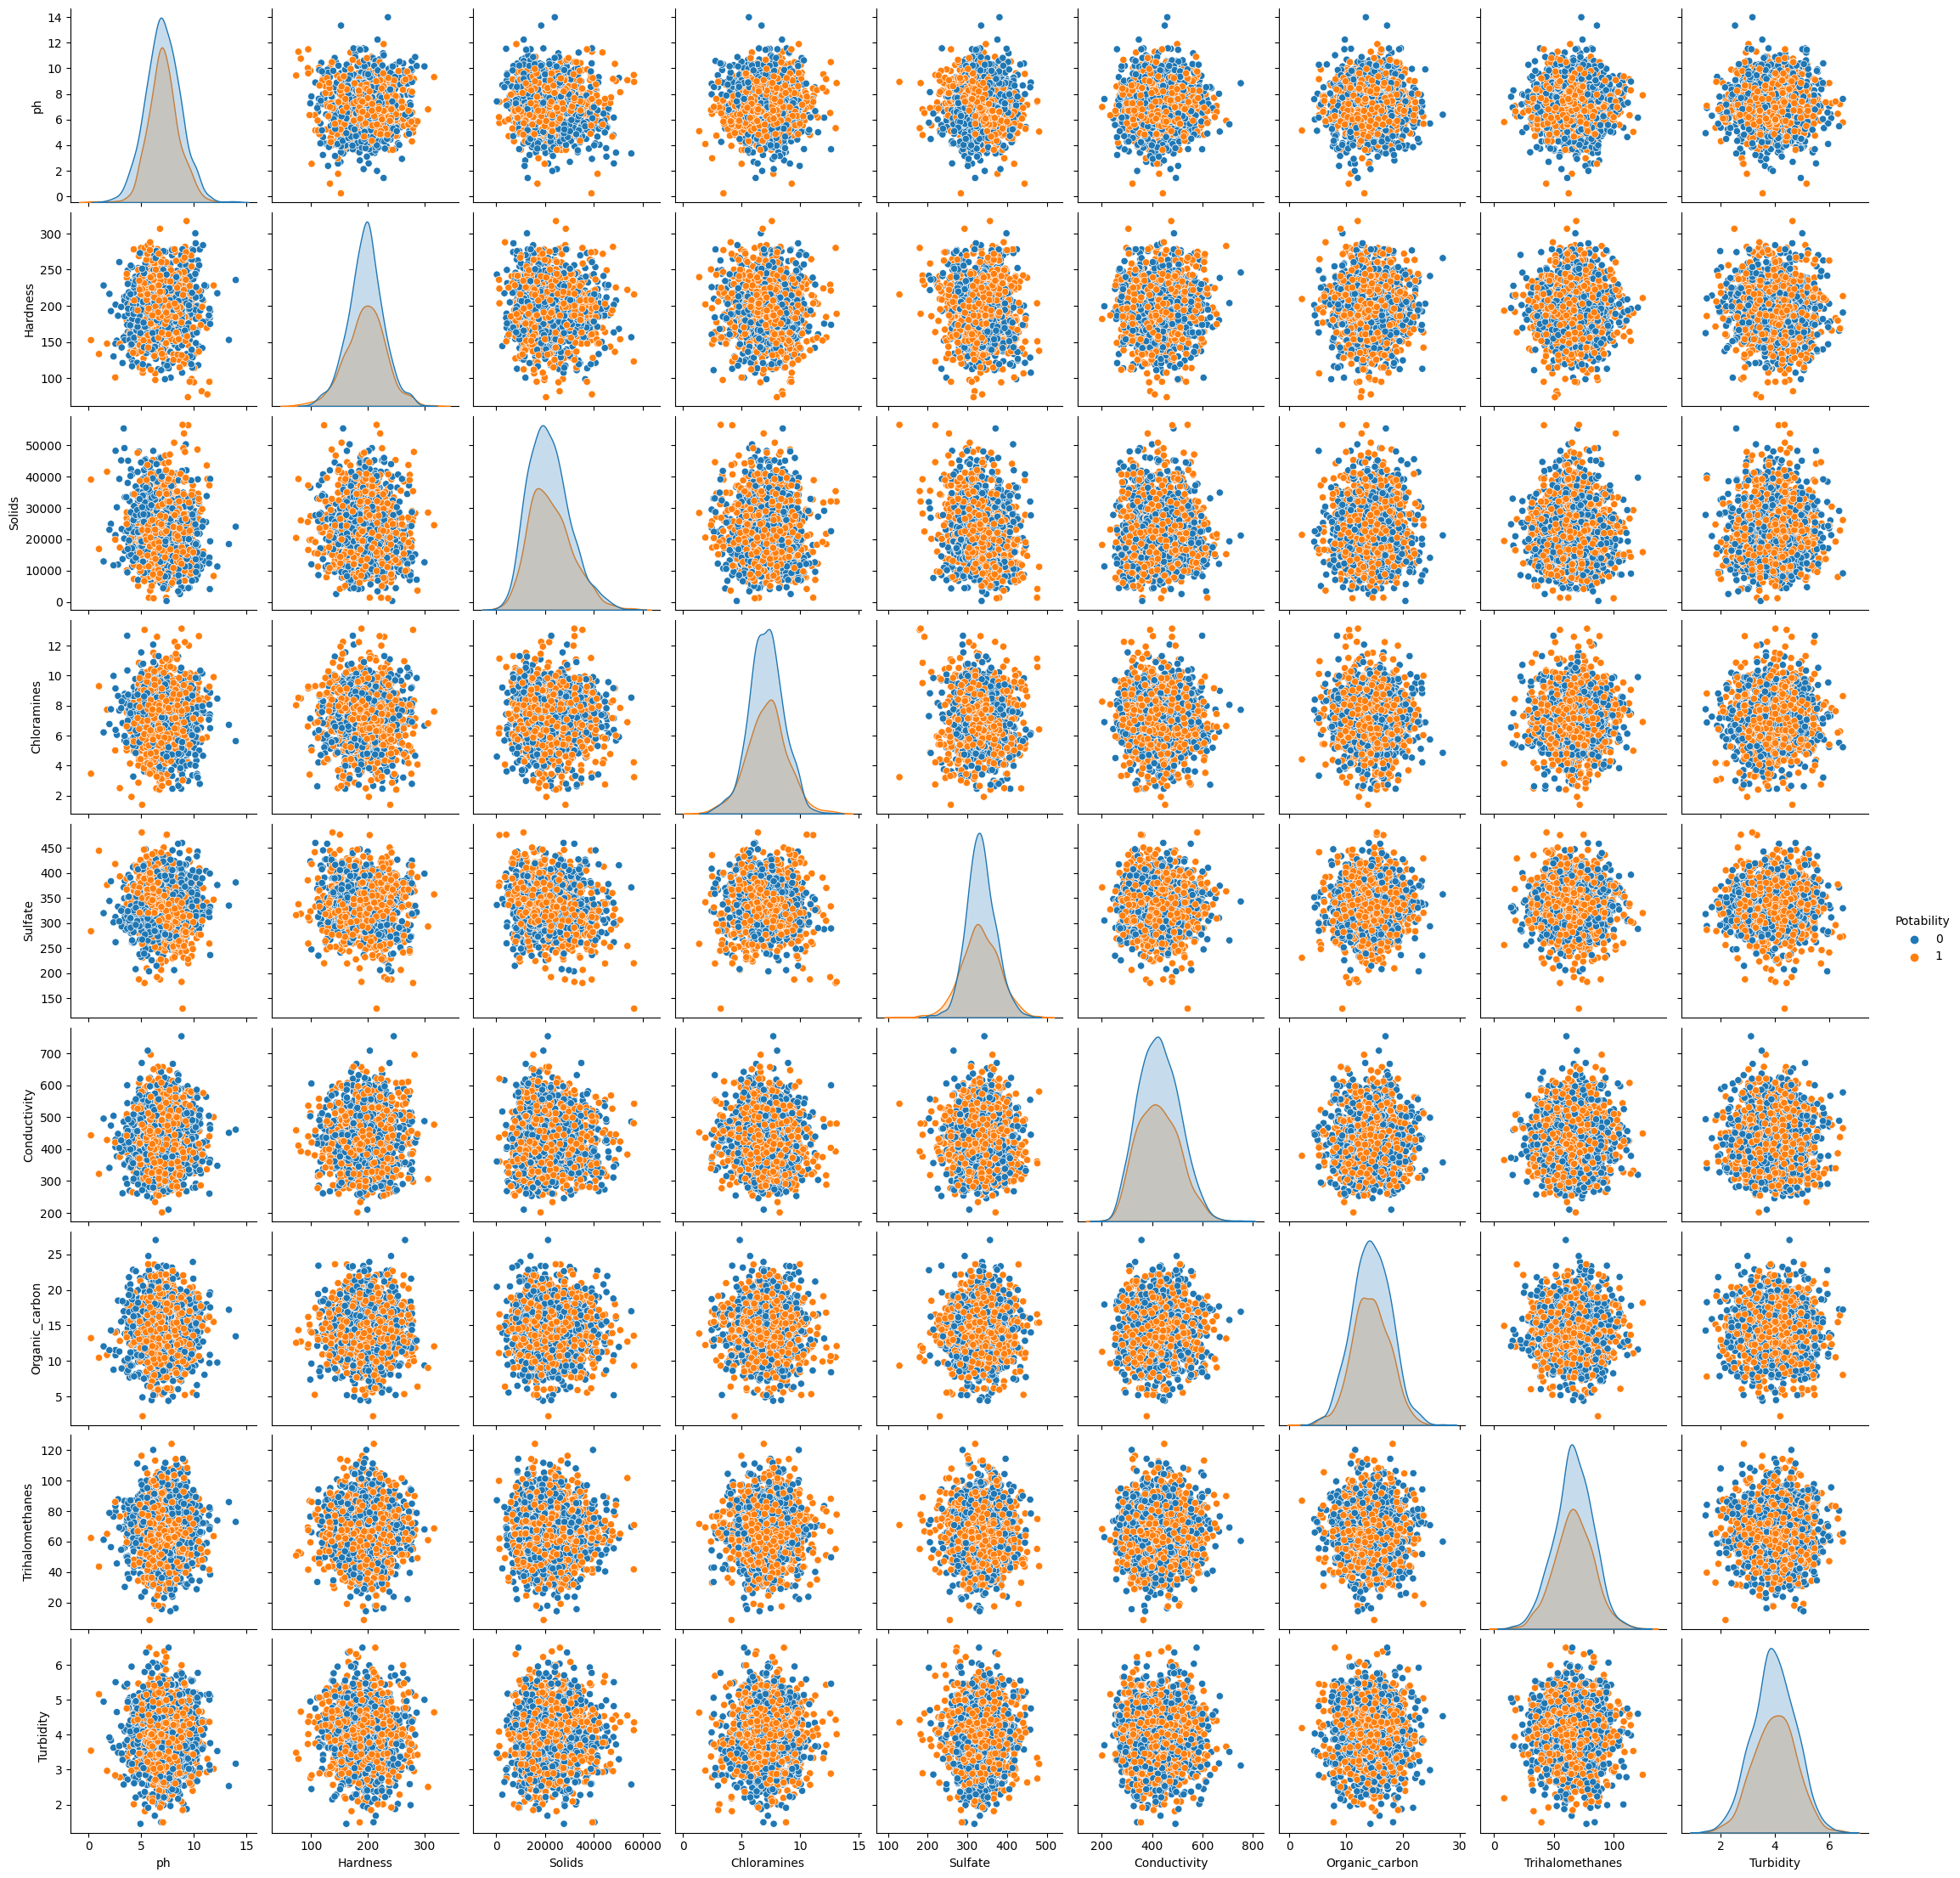

In [ ]:
sns.pairplot(data=data, hue='Potability')

Кажется, что объекты не являются линейно разделимыми.

Взгляну на матрицу корреляций.

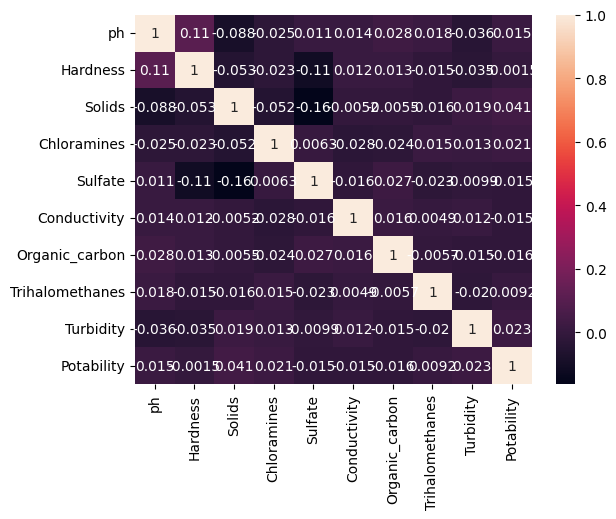

In [ ]:
sns.heatmap(data.corr(), annot=True)
None

Мультиколлинеарности нет.

Попробую выяснить наверняка, на сколько применима логистическая регрессия.

# Реализация модели: логистическая регрессия

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Logistic_regression(BaseEstimator, ClassifierMixin):
    
    def __init__(self, lr = 0.1, epoches = 1, batchSize = 10, alpha = 0.0001):
        self.lr = lr
        self.epoches = epoches
        self.batchSize = batchSize
        self.alpha = alpha

    def simoid(self, z):
        return 1/(1+np.exp(-z))
        
    def fit(self, X, y):
        self.n_classes = np.unique(y)
        self.theta = np.random.normal(0, 1, size=X.shape[1]+1)
        X = pd.DataFrame(X)
        X.insert(0, '-', 1)
        
        for _ in range(self.epoches):
            for i in range(self.batchSize, len(X), self.batchSize):
                batchX = X[i-self.batchSize:i]
                batchY = y[i-self.batchSize:i]

                pred = self.simoid(np.dot(self.theta, batchX.T))
                grad = 2*self.alpha*self.theta+np.dot(pred-batchY, batchX)

                self.theta -= self.lr*grad
        return self

    def predictProba(self, X):
        X = X.copy()
        X.insert(0, '-', 1)
        y = self.simoid(X)
        
        self.y = pd.Series(y)
        return pd.Series(y)
    
    def predict(self, X):
        X = pd.DataFrame(X)
        X = X.copy()
        X.insert(0, '-', 1)
        y = np.around(self.simoid(np.dot(self.theta, X.T)))
        self.y = pd.Series(y)
        return pd.Series(y)

Обучу модель. С подбором гиперпараметров.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
import sklearn
import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data.drop('Potability', axis=1).to_numpy(), 
                                                                            data['Potability'].to_numpy(), 
                                                                            train_size=0.8)

In [ ]:
parameters = {'classifier__alpha': [0.01, 0.001, 0.0001],
              'classifier__batchSize': [10, 100, 1000],
              'classifier__epoches': [1, 10, 100],
              'classifier__lr': [0.1, 0.01, 0.001]}

logistic_regression_cv = sklearn.model_selection.GridSearchCV(Pipeline([('scaler', StandardScaler()), ('classifier', Logistic_regression())]), 
                                                              parameters)

logistic_regression_cv.fit(X_train, y_train)
print(logistic_regression_cv.best_params_, logistic_regression_cv.best_score_, sep='\n')

{'classifier__alpha': 0.01, 'classifier__batchSize': 1000, 'classifier__epoches': 100, 'classifier__lr': 0.001}
0.6001277065072269


accuracy_score:  0.6129032258064516
recall_score:  0.049689440993788817


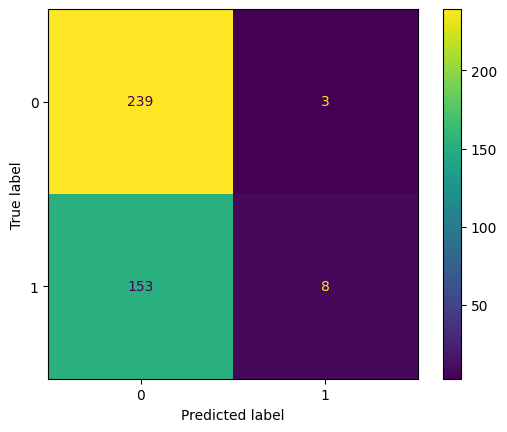

In [ ]:
predictions =  logistic_regression_cv.best_estimator_.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)

print('accuracy_score: ', sklearn.metrics.accuracy_score(y_test, predictions))
print('recall_score: ', sklearn.metrics.recall_score(y_test, predictions))
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot()
None

Даже с перебором гиперпараметров не удалось добиться хорошей матрицы ошибок, что подтверждает предположение, сделанное при анализе данных.

Сравню с готовым решением из sklearn.

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
parameters = {'classifier__alpha': [0.01, 0.1, 0.3],
              'classifier__max_iter': [100, 300, 1000]}

logistic_regression_cv = sklearn.model_selection.GridSearchCV(Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier(loss='log_loss'))]), 
                                                              parameters)

logistic_regression_cv.fit(X_train, y_train)
print(logistic_regression_cv.best_params_, logistic_regression_cv.best_score_, sep='\n')

{'classifier__alpha': 0.01, 'classifier__max_iter': 1000}
0.5988757957469864


accuracy_score:  0.6004962779156328
recall_score:  0.0


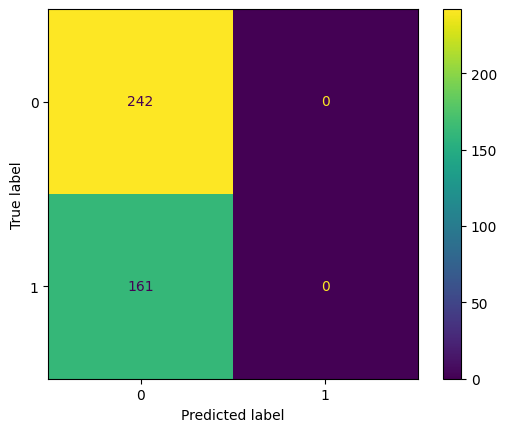

In [ ]:
predictions =  logistic_regression_cv.best_estimator_.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)

print('accuracy_score: ', sklearn.metrics.accuracy_score(y_test, predictions))
print('recall_score: ', sklearn.metrics.recall_score(y_test, predictions))
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot()
None

Результат аналогичен, данные не являются линейно разделимыми.